# Capstone-Project-aiml
## AIML Online Capstone - Pneumonia Detection Challenge
### Project Objectives
The objective of the project is,  Learn to how to do build an Object Detection Model  Use transfer learning to fine-tune a model.  Learn to set the optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc.  Read different research papers of given domain to obtain the knowledge of advanced models for the given problem.

## The Real Problem
### What is Pneumonia?
Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2017, 920,000 children under the age of 5 died from the disease. It requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR. However, the diagnosis of pneumonia on CXR is complicated because of a number of other conditions in the lungs such as fluid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or postradiation or surgical changes. Outside of the lungs, fluid in the pleural space (pleural effusion) also appears as increased opacity on CXR. When available, comparison of CXRs of the patient taken at different time points and correlation with clinical symptoms and history are helpful in making the diagnosis. CXRs are the most commonly performed diagnostic imaging study. A number of factors such as positioning of the patient and depth of inspiration can alter the appearance of the CXR, complicating interpretation further. In addition, clinicians are faced with reading high volumes of images every shift. Pneumonia Detection Now to detection Pneumonia we need to detect Inflammation of the lungs. In this project, you’re challenged to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

### Business Domain Value
Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology). Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

### Project Description
In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images:

Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. Details about the data and dataset files are given in below link, https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

#### Pre-Processing, Data Visualization, EDA
 Exploring the given Data files, classes and images of different classes.  Dealing with missing values  Visualization of different classes  Analysis from the visualization of different classes.

#### Model Building
 Building a pneumonia detection model starting from basic CNN and then improving upon it.  Train the model  To deal with large training time, save the weights so that you can use them when training the model for the second time without starting from scratch.

#### Test the Model, Fine-tuning and Repeat
 Test the model and report as per evaluation metrics  Try different models  Set different hyper parameters, by trying different optimizers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping etc. for these models to fine-tune them  Report evaluation metrics for these models along with your observation on how changing different hyper parameters leads to change in the final evaluation metric.

### Reference
Acknowledgment for the datasets. https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements

In [1]:
#!pip install tensorflow==1.15
#!pip install tensorflow-gpu==1.15
#!pip install keras==2.2.4
!pip install pydicom

In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
import random
random.seed(0)
import warnings
warnings.filterwarnings('ignore')

Installing pydicom

In [4]:
import os
import pandas as pd
import pydicom as dcm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tqdm.notebook as tq
from copy import deepcopy
import glob
import datetime
import cv2
import pytz
import multiprocessing
import hashlib
from sklearn.utils import shuffle
import imgaug as ia
import sys
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

%matplotlib inline 

In [5]:
from keras.models import Model
from keras.layers import Lambda, Input, Conv2D, Conv2DTranspose, UpSampling2D, Concatenate
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
import importlib

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Install kaggle to download the dataset
!pip install -q kaggle

### Setting up kaggle to download datasets

- Please setup the kaggle_path where you have kept the kaggle.json file
- Or create the directory structure in your google drive like MyDrive/Colab/.kaggle/ and upload kaggle.json to this location

In [8]:
# Ensure you have setup kaggle.json with the required API token and saved it to your google drive mounted above.
# Provide the location of the .kaggle/kagle.json file
kaggle_path = '/content/drive/MyDrive/Colab/.kaggle/'
os.chdir(kaggle_path)
#!export KAGGLE_CONFIG_DIR=/content/drive/MyDrive/Colab/.kaggle/

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle --version

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Kaggle API 1.5.12


In [9]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [10]:
# Kaggle api version should be 1.5.12 or higher
!kaggle --version

Kaggle API 1.5.12


### Download datasets from kaggle
- Please setup the destination path where you want to install the dataset
- Or create the directory structure as MyDrive/Colab/Capstone Project/ to store the datasets in your google drive

In [11]:
project_path = '/content/drive/MyDrive/Colab/Capstone Project/'
os.chdir(project_path)
data_path = project_path + 'dataset'

if not os.path.exists(data_path):
    os.makedirs(data_path)

os.chdir(data_path)

# Downloading kaggle dataset from Pneumonia detection challenge
file_path = data_path + '/rsna-pneumonia-detection-challenge.zip'
if not os.path.exists(file_path):
  !kaggle competitions download -q -c rsna-pneumonia-detection-challenge

In [12]:
os.getcwd()

'/content/drive/MyDrive/Colab/Capstone Project/dataset'

In [13]:
sys.path.append(os.path.join(data_path, 'Unet'))

from unet.config import Config
from unet import utils
import unet.model as modellib
from unet import visualize
from unet.model import log

Dataset is ready to be read and to do EDA

In [14]:
!ls

filtered_data_aug.csv		   pneumonia_data_orig_aug_res_256.npz
filtered_image_array_aug_orig.npz  pneumonia_data_orig_test_256.npz
filtered_image_test_orig.npz	   rsna-pneumonia-detection-challenge.zip
filtered_res_masks_128.npz	   stage_2_detailed_class_info.csv
filtered_res_test_masks_128.npz    stage_2_detailed_class_info_updated.csv
filtered_test_data.csv		   stage_2_sample_submission.csv
LRFinder			   stage_2_test_images
Mask_RCNN			   stage_2_train_images
maskrcnn20210522T1051		   stage_2_train_labels.csv
maskrcnn20210522T1123		   tmp.hdf5
maskrcnn20210522T1141		   Unet
merged_data_aug.csv		   unet_best_weights.hdf5


Unzip the file

In [15]:
import zipfile
if not os.path.exists(data_path + '/' + 'stage_2_train_images'):
  zip_ref = zipfile.ZipFile(data_path + '/rsna-pneumonia-detection-challenge.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()

Load Labels

In [16]:
def md5Checksum(file):
  with open(data_path + '/' + 'stage_2_train_images' + '/' + file + '.dcm', "rb") as f:
    bytes = f.read()
    file_hash = hashlib.md5(bytes).hexdigest()
  return file_hash

In [17]:
labels_df = pd.read_csv(data_path + '/stage_2_train_labels.csv')
det_class_info_df = pd.DataFrame()
if not os.path.exists(data_path + '/stage_2_detailed_class_info_updated.csv'):
  det_class_info_df = pd.read_csv(data_path + '/stage_2_detailed_class_info.csv')
  # Removing duplicates
  det_class_info_df=det_class_info_df.drop_duplicates().reset_index(drop=True)
  det_class_info_df['Target'] = det_class_info_df['class'].apply(lambda x: 1 if x =='Lung Opacity' else 0)
  filelist= det_class_info_df['patientId'].to_numpy()
  # Checksum to identify duplicate images
  checksum=[]
  for file in filelist:
    checksum.append(md5Checksum(file))
  checksum = np.array(checksum)
  det_class_info_df['checksum'] = checksum
  det_class_info_df.to_csv(data_path + '/stage_2_detailed_class_info_updated.csv')
else:
  det_class_info_df = pd.read_csv(data_path + '/stage_2_detailed_class_info_updated.csv', index_col=[0]) 

In [18]:
merged_class_df = labels_df.merge(det_class_info_df[['patientId','class', 'checksum']], left_on='patientId', right_on='patientId', how='inner')

In [19]:
merged_class_df.head()

,patientId,x,y,width,height,Target,class,checksum
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,78f614e5b22357018e0c50f08bddb412
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,ee3b52fc977cbf1e4c2210b29221e630
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0cdb347053dd580952be05667c20a593
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,d016ec2dd9a89189afba8183c12a9e1e
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,12657f14d27e815bd3026c6ffdfbae3b


In [20]:
print ('There are', det_class_info_df['checksum'].nunique(), 'checksum values')

There are 26684 checksum values


In [21]:
print('There are', det_class_info_df['patientId'].nunique(), 'patients')

There are 26684 patients


There are no duplicates images.

In [22]:
merged_class_df[(merged_class_df['Target']==1)].groupby('patientId')['class'].count().max()

4

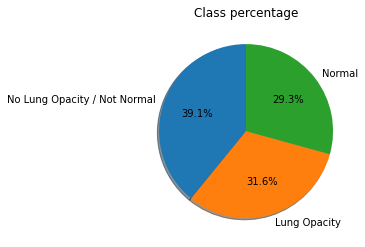

In [23]:
class_info=merged_class_df["class"].value_counts()
labels = (np.array(class_info.index))
sizes = (np.array((class_info / class_info.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Class percentage")
plt.show()

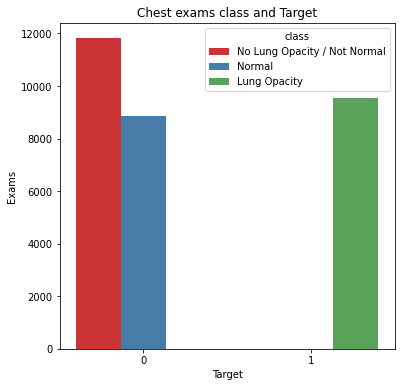

In [24]:
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
tmp = merged_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set1')
plt.title("Chest exams class and Target")
plt.show()

In [25]:
# Extract one image and process the DICOM information.
patientId = det_class_info_df.iloc[0]['patientId']
dicom_file_dataset = dcm.read_file(data_path + '/' + 'stage_2_train_images' + '/' + patientId + '.dcm' )

In [26]:
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

## Filter Data

In [27]:
def filterPatientsByCriteria(criterion):
    x = 1
    for key in criterion.keys():
      if (x==1):
        filt_class_df = det_class_info_df[det_class_info_df['class']==key].sample(int(criterion.get(key)))
      else:
        filt_class_df=filt_class_df.append(det_class_info_df[det_class_info_df['class']==key].sample(int(criterion.get(key))))
      x = x + 1
    return filt_class_df

In [28]:
def generateAugmentationList(filt_class_df, augm_count):
  rowlist=[]
  augm_data=[]
  for i in range(augm_count):
    exists=True 
    while exists:
      n=random.randint(0,filt_class_df.shape[0]-1)
      if n in rowlist:
        exists=True
      else:
        rowlist.append(n)
        row = filt_class_df.iloc[n]
        augm_data.append(['xxx ' + row['patientId'], row['class'], row['Target'], 'aug'])
        exists=False
  filt_class_df=filt_class_df.append(pd.DataFrame(augm_data, 
               columns=[ 'patientId', 'class', 'Target', 'row_type']),
               ignore_index = True)
  return filt_class_df

In [29]:
def get_filtered_data_criterion(criterion, aug_count):
  filt_class_df = pd.DataFrame()
  if not os.path.exists(data_path + '/' + 'filtered_data_aug.csv'):
    # Filter data based on the criterion
    filt_class_df = filterPatientsByCriteria(criterion)
    # Dropping the checksum from the filtered dataset as it is not relevant
    filt_class_df.drop(['checksum'], axis=1, inplace=True)
    # Add a new column with default value of 'orig'. The augmented row will have row_type = 'aug'
    filt_class_df['row_type'] = 'orig'
    # Append the augmented rows to the list
    filt_class_df=generateAugmentationList(filt_class_df, aug_count) # Augmenting 3000 images from the filtered list
    filt_class_df=shuffle(filt_class_df)
    filt_class_df.reset_index(drop=True)
    # Export the data to CSV
    filt_class_df.to_csv(data_path + '/' + 'filtered_data_aug.csv')
  else:
    filt_class_df = pd.read_csv(data_path + '/' + 'filtered_data_aug.csv')
  return filt_class_df

In [30]:
# Set the criterion = {} to load all data
criterion={'Lung Opacity':3000, 
           'No Lung Opacity / Not Normal': 400, 
           'Normal': 400}

In [31]:
filt_class_df = pd.DataFrame()
filt_class_df =  get_filtered_data_criterion(criterion, 3000)

In [32]:
filt_class_df.head()

,Unnamed: 0,patientId,class,Target,row_type
0,743,1d1c51b5-1cc9-4d0c-8073-5f1cfd598f76,Lung Opacity,1,orig
1,699,66c52ba5-c91d-4f0c-af96-18148fd9dd66,Lung Opacity,1,orig
2,4447,xxx 2a55f0bc-4943-4473-8f08-5c0a36fdc929,Normal,0,aug
3,382,3862449a-cc8b-40da-91a0-a1437618e65c,Lung Opacity,1,orig
4,3671,b4bd9d9f-9dee-47f0-a734-afbfb0e554cf,Normal,0,orig


In [33]:
def filterTestPatientsByCriteria(criterion):
    x = 1
    # Create a list of patients that are not in training dataset
    delta_df = det_class_info_df[~det_class_info_df.patientId.isin(filt_class_df.patientId)]
    for key in criterion.keys():
      if (x==1):
        filt_test_class_df = delta_df[delta_df['class']==key].sample(int(criterion.get(key)))
      else:
        filt_test_class_df=filt_test_class_df.append(delta_df[delta_df['class']==key].sample(int(criterion.get(key))))
      x = x + 1
    return filt_test_class_df

In [34]:
# Criteria for loading test data
criterion={'Lung Opacity':300, 
           'No Lung Opacity / Not Normal': 25, 
           'Normal': 25}

In [35]:
filt_test_class_df = pd.DataFrame()
if not os.path.exists(data_path + '/' + 'filtered_test_data.csv'):
  filt_test_class_df =  filterTestPatientsByCriteria(criterion)
  filt_test_class_df.to_csv(data_path + '/' + 'filtered_test_data.csv')
else:
  filt_test_class_df = pd.read_csv(data_path + '/' + 'filtered_test_data.csv', index_col=[0])

In [36]:
filt_test_class_df.reset_index(drop=True)

,patientId,class,Target,checksum
0,b3cbe758-859f-4ace-8968-4953ca48dfc7,Lung Opacity,1,474c09e4986ecec79ae9ceb76c1b9c7d
1,9cf3c0e7-f25c-4358-b5a9-aca2e0b6f33e,Lung Opacity,1,c5a4dd680862fecf5a31952edf6f697a
2,fff0b503-72a5-446a-843d-f3d152e39053,Lung Opacity,1,2ecae1e26cacd4fed15d7d818f4958ba
3,e0cc9552-af6e-4b2e-8744-78689b0f2aaf,Lung Opacity,1,40262a87f2c8484b7ef44c6718d645da
4,af335d18-feec-4942-9831-3e25ca20e7e3,Lung Opacity,1,4eac80b41339e8233b88e61429a35532
...,...,...,...,...
345,8214be18-4b1c-4042-a3f9-c1929c516ffb,Normal,0,78f529648b421ca121968d3bf3401e61
346,9213dc17-1267-42a4-a71d-546a4d994a4a,Normal,0,6c69493495a1691fac282eb5204e8f86
347,9709cc26-3db4-4fc4-a026-2deb53cc5bda,Normal,0,75c3db6bba4f099e41e6d3f2a3689e37
348,35ce8c4b-7dbc-49ae-b141-ee593aa2180e,Normal,0,efb5fa60459d068262ab5b1b2a339cf5


## Augment Data

In [37]:
def getBoundingBox(patientId, shape):
  bbs=[]
  for idx_a, row in merged_class_df[(merged_class_df['patientId']==patientId)].iterrows():
    bbs.append(BoundingBox(x1=row['x'], y1=row['y'], x2=row['x']+row['width'], y2=row['y']+row['height']))
  return BoundingBoxesOnImage(bbs, shape=shape)

In [38]:
def getImage(patientId):
  dcm_img = dcm.read_file(data_path +'/' + 'stage_2_train_images' + '/' + patientId + '.dcm').pixel_array
  return dcm_img

In [39]:
def augment(patientId, target):
  dcm_img = getImage(patientId)
  aug_bbs=None
  augmentation = iaa.Sequential([
      iaa.Fliplr(0.5),
      iaa.OneOf([ ## geometric transform
          iaa.Affine(
              scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
              translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
              rotate=(-2, 2),
              shear=(-1, 1),
          ),
          iaa.PiecewiseAffine(scale=(0.001, 0.025)),
      ]),
      iaa.OneOf([ ## brightness or contrast
          iaa.Multiply((0.9, 1.1)),
          iaa.ContrastNormalization((0.9, 1.1)),
      ]),
      iaa.OneOf([ ## blur or sharpen
          iaa.GaussianBlur(sigma=(0.0, 0.1)),
          iaa.Sharpen(alpha=(0.0, 0.1)),
      ])
  ], random_order=True)

  det = augmentation.to_deterministic()
  aug_image = det.augment_image(dcm_img)
  if target == 1:
    bbs = getBoundingBox(patientId, dcm_img.shape)
    aug_bbs = det.augment_bounding_boxes(bbs)
  return aug_image, aug_bbs

In [40]:
def filter_augment_generator(merged_class_df):
  image_array=[]
  merge_aug_data=[]
  m = 0
  count = 200
  for idx, row in filt_class_df.iterrows():
    m += 1
    if row['row_type']=='orig':
      orig_img=getImage(row['patientId'])
      image_array.append(orig_img)
    else:
      aug_image, aug_bbs = augment(row['patientId'][4: :], row['Target'])
      image_array.append(aug_image)
      if row['Target']==1:
        for i in range(len(aug_bbs.bounding_boxes)):
          aug_bb = aug_bbs.bounding_boxes[i]
          x, y, width, height = aug_bb.x1, aug_bb.y1, aug_bb.x2-aug_bb.x1, aug_bb.y2-aug_bb.y1
          merge_aug_data.append([row['patientId'], x, y, width, height, row['Target'], row['class']])
      else:
        merge_aug_data.append([row['patientId'], np.nan, np.nan, np.nan, np.nan, row['Target'], row['class']])
    if m%count == 0:
      print (str(m))
  merged_class_df=merged_class_df.append(pd.DataFrame(merge_aug_data, 
              columns=[ 'patientId', 'x', 'y', 'width', 'height', 'Target', 'class']),
              ignore_index = True)
  return merged_class_df, np.array(image_array)

In [41]:
def load_filtered_augmented_images(merged_class_df):
  orig_aug_array=[]
  if not os.path.exists(data_path + '/' + 'filtered_image_array_aug_orig.npz'):
    merged_class_df, orig_aug_array = filter_and_augment(merged_class_df)
    np.savez_compressed(data_path + '/' + 'filtered_image_array_aug_orig.npz', images=orig_aug_array)
    merged_class_df.to_csv(data_path + '/' + 'merged_data_aug.csv')
  else:
    orig_aug_array = np.load(data_path + '/' + 'filtered_image_array_aug_orig.npz', allow_pickle=True)['images']
    if os.path.exists(data_path + '/' + 'merged_data_aug.csv'):
      merged_class_df = pd.read_csv(data_path + '/' + 'merged_data_aug.csv')
  return merged_class_df, orig_aug_array

In [42]:
orig_aug_array=[]
merged_class_df, orig_aug_array = load_filtered_augmented_images(merged_class_df)

In [43]:
orig_aug_array.shape

(6800, 1024, 1024)

In [44]:
merged_class_df.tail()

,Unnamed: 0,patientId,x,y,width,height,Target,class,checksum
34643,34643,xxx dc2a32fa-d49c-4c49-bcdc-3ae6c394fbc9,158.207031,463.094849,133.645325,90.395325,1,Lung Opacity,NaN
34644,34644,xxx c36d4722-8751-4593-b04e-36b5c86055db,NaN,NaN,NaN,NaN,0,Normal,NaN
34645,34645,xxx b3cb6b71-3e7b-4287-a4e1-49a443d31215,497.970703,197.712875,231.567047,521.193909,1,Lung Opacity,NaN
34646,34646,xxx b3cb6b71-3e7b-4287-a4e1-49a443d31215,135.838257,228.696991,236.973389,616.219116,1,Lung Opacity,NaN
34647,34647,xxx 18774506-f9cb-497c-898f-0bade580f342,306.430725,77.581459,242.289429,331.935944,1,Lung Opacity,NaN


Loading Test Images

In [45]:
def loadTestImages():
  test_image_array=[]
  for idx, row in filt_test_class_df.iterrows():
    test_image_array.append(getImage(row['patientId']))
  return np.array(test_image_array)

In [46]:
test_orig_array=[]
if not os.path.exists(data_path + '/' + 'filtered_image_test_orig.npz'):
  test_orig_array=loadTestImages()
  np.savez_compressed(data_path + '/' + 'filtered_image_test_orig.npz', images=test_orig_array)
else:
  test_orig_array = np.load(data_path + '/' + 'filtered_image_test_orig.npz', allow_pickle=True)['images']

In [47]:
test_orig_array.shape

(350, 1024, 1024)

## Resize Images

In [48]:
orig_img_size=1024
do_not_resize=False
target_img_size=256
if do_not_resize:
  target_mask_size = int(orig_img_size/2)
else:
  target_mask_size=int(target_img_size/2)

In [49]:
# Convert each file
def resizeImage(idx):
    try:
        res_array = resize(orig_aug_array[idx], (target_img_size, target_img_size), mode='symmetric')
    except Exception as e:
        print(file)
        print(e)
    return res_array

In [50]:
# Convert all files within a folder
IST=pytz.timezone('Asia/Kolkata')
def resizeImages():
    res_array=[]
    cnt=filt_class_df.shape[0]
    print('Resizing', str(cnt), 'files from size - 1024x1024 to', str(target_img_size) + 'x' + str(target_img_size))
    print ('-----------------------------------------------------')
    current_time = datetime.datetime.now(IST).strftime("%H:%M:%S")
    print("Start Time =", current_time)
    for idx in range(cnt):
      ia = resizeImage(idx)
      res_array.append(ia)
    current_time = datetime.datetime.now(IST).strftime("%H:%M:%S")
    print("End Time =", current_time)
    return np.array(res_array)    

In [51]:
#Loading resized image array. 
#If pneumonia_data_orig_aug_res_<>.npz doesn't exist, then resize first and save it 
def load_image():
  resized_array=[]
  if not os.path.exists(data_path + '/' + 'pneumonia_data_orig_aug_res_' + str(target_img_size) + '.npz'):
    resized_array = resizeImages()
    np.savez_compressed(data_path + '/' + 'pneumonia_data_orig_aug_res_' + str(target_img_size) + '.npz', images=resized_array)
  else:
    resized_array = np.load(data_path + '/' + 'pneumonia_data_orig_aug_res_' + str(target_img_size) + '.npz', allow_pickle=True)['images']
  return resized_array

In [52]:
resized_array=[]
if do_not_resize:
  resized_array=orig_aug_array
else:
  resized_array = load_image()
  del orig_aug_array

In [53]:
print(resized_array.shape)

(6800, 256, 256)


Resize test images

In [54]:
def load_test_images():
  resized_test_array=[]
  if not os.path.exists(data_path + '/' + 'pneumonia_data_orig_test_' + str(target_img_size) + '.npz'):
    cnt=filt_test_class_df.shape[0]
    for idx in range(cnt):
      ia = resize(test_orig_array[idx], (target_img_size, target_img_size), mode='symmetric')
      resized_test_array.append(ia)
    np.savez_compressed(data_path + '/' + 'pneumonia_data_orig_test_' + str(target_img_size) + '.npz', images=resized_test_array)
  else:
    resized_test_array = np.load(data_path + '/' + 'pneumonia_data_orig_test_' + str(target_img_size) + '.npz', allow_pickle=True)['images']
  return np.array(resized_test_array)

In [55]:
if do_not_resize:
  resized_test_array=test_orig_array
else:
  resized_test_array=load_test_images()
  del test_orig_array

In [56]:
print(resized_test_array.shape)

(350, 256, 256)


Defining function for plotting images

In [57]:
# This function is to validate the JPG display against the original
def plot_dcm_images(ax, patientId, c, bb_box=False):
  dcm_data = dcm.read_file(data_path +'/' + 'stage_2_train_images/' + patientId + '.dcm')
  ax[c//3, c%3].imshow(dcm_data.pixel_array, cmap=plt.cm.bone)
  ax[c//3, c%3].set_title('ID: {}\n'.format(patientId))
  if bb_box:
    for idx, row in merged_class_df[merged_class_df['patientId']==patientId].iterrows():
      ax[c//3, c%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                                        width=row['width'],height=row['height'],
                                        linewidth=1, edgecolor='r', facecolor='none'))

In [58]:
# Pass bb_box as True for target 1 to draw bounding boxes
def plot_images(ax, patientId, c, bb_box=False, col=3):
  global target_img_size
  idx=np.where(filt_class_df['patientId']==patientId)
  if do_not_resize:
    target_img_size = orig_img_size
  scale=target_img_size/orig_img_size
  ax[c//col, c%col].imshow(resized_array[idx].reshape(target_img_size, target_img_size), cmap=plt.cm.bone)
  ax[c//col, c%col].set_title('ID: {}\n'.format(patientId))
  if bb_box:
    for idx, row in merged_class_df[merged_class_df['patientId']==patientId].iterrows():
      ax[c//col, c%col].add_patch(Rectangle(xy=(int(row['x']*scale), int(row['y']*scale)),
                 width=int(row['width']*scale),height=int(row['height']*scale),
                 linewidth=2, edgecolor="white",fill=False))

Plot images with bounding boxes of subjects that were detected with Pneumonia

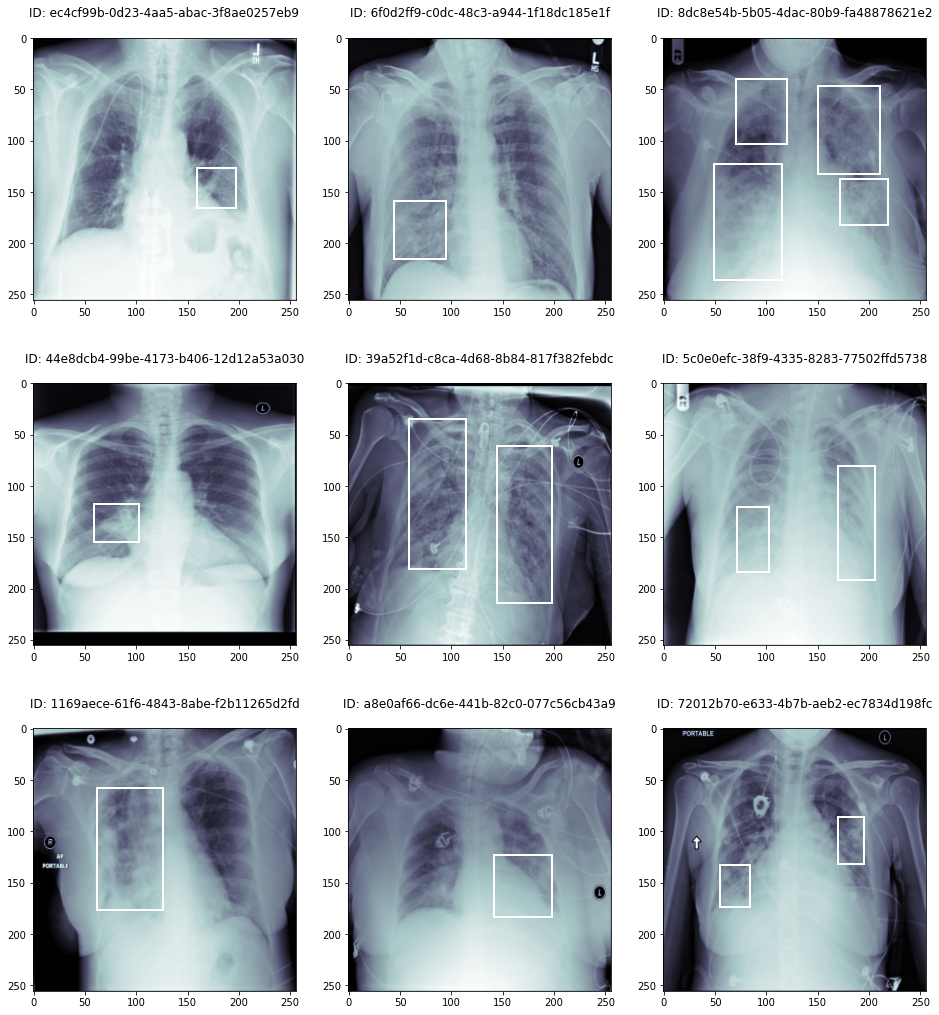

In [59]:
c = 0
f, ax = plt.subplots(3,3, figsize=(16,18))
# Array for storing the ids that can be used to display DCM 
image_ids=[]
# Target = 1
for patientId in filt_class_df[(filt_class_df['Target']==1) & (filt_class_df['patientId'].str.startswith('xxx ')==False)].patientId.sample(9):
  image_ids.append(patientId)
  plot_images (ax, patientId, c, True)
  c = c + 1

Plot DCM images

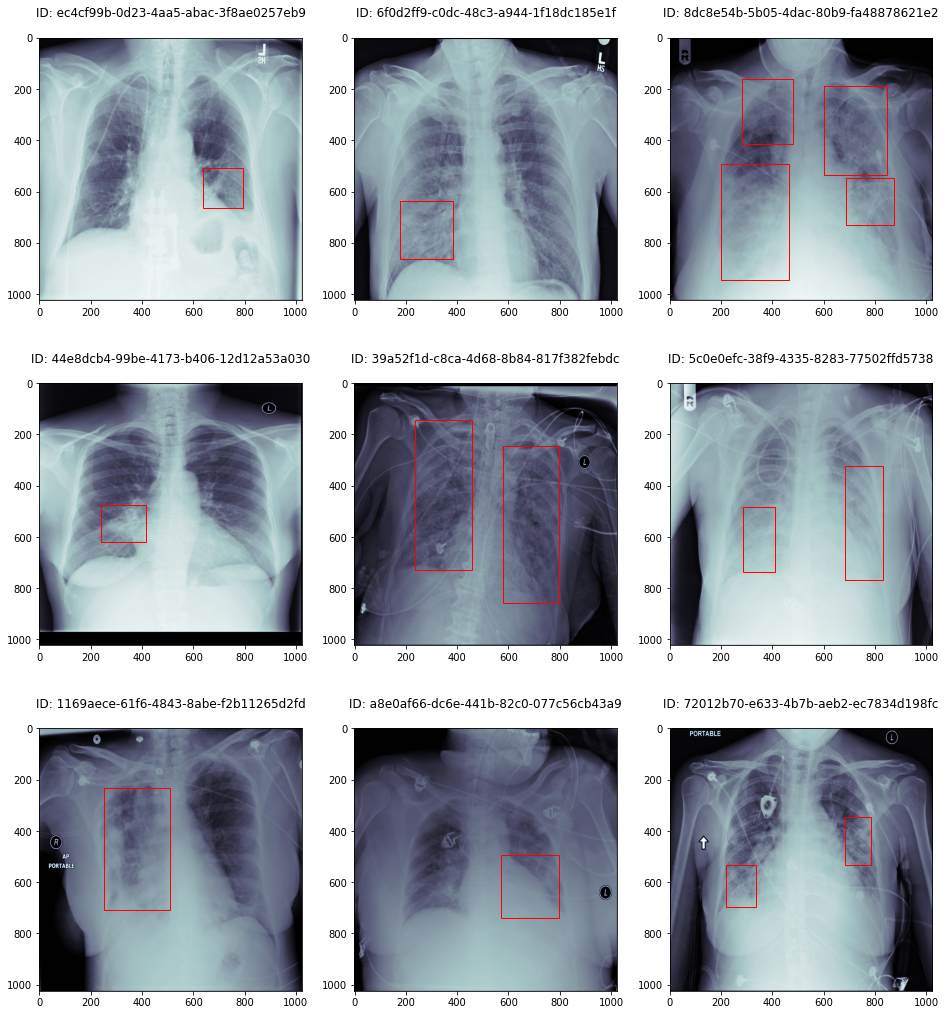

In [60]:
c = 0
f, ax = plt.subplots(3,3, figsize=(16,18))
# Target = 1
for patientId in image_ids:
  plot_dcm_images (ax, patientId, c, True)
  c = c + 1

Plot images of subjects with no Pneumonia

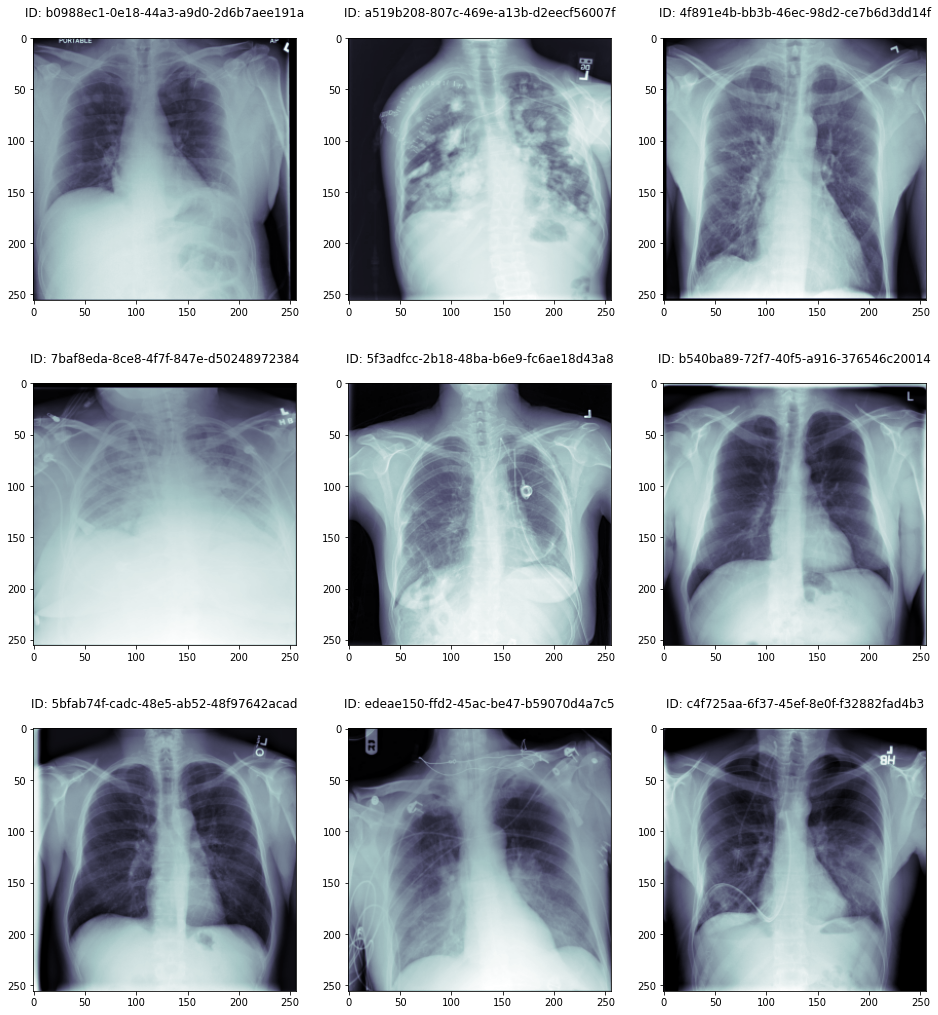

In [61]:
c = 0
f, ax = plt.subplots(3,3, figsize=(16,18))
# Array for storing the ids that can be used to display DCM 
image_ids1=[]
# Target = 0
for patientId in filt_class_df[(filt_class_df['Target']==0) & (filt_class_df['patientId'].str.startswith('xxx ')==False)].patientId.sample(9):
  image_ids1.append(patientId)
  plot_images (ax, patientId, c, False)
  c = c + 1

Plot augmented images side by side with original

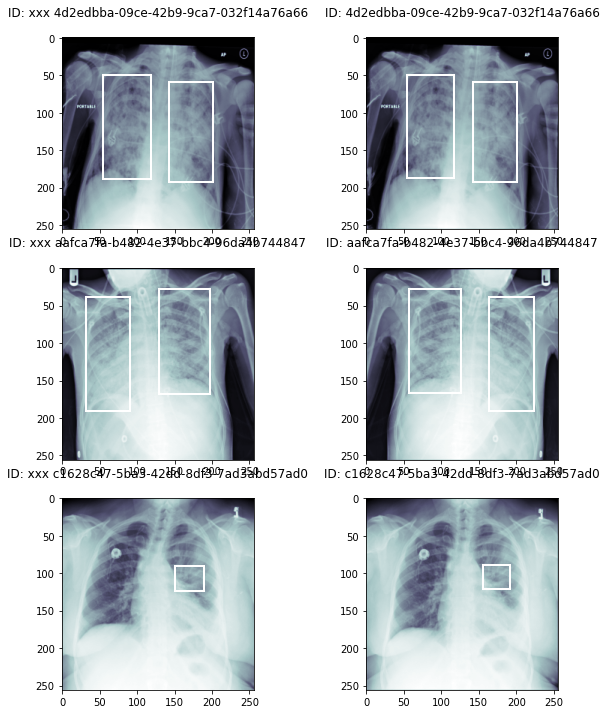

In [62]:
c = 0
f, ax = plt.subplots(3,2, figsize=(10,12))
for patientId in filt_class_df[(filt_class_df['Target']==1) & (filt_class_df['patientId'].str.startswith('xxx ')==True)].patientId.sample(3):
  plot_images (ax, patientId, c, True, 2)
  c = c + 1
  patientId = patientId[4::]
  plot_images (ax, patientId, c, True, 2)
  c = c + 1  

Plot masks for subjects with Pneumonia

In [63]:
def getMask(patientId, imgShape):
  image_mask=np.zeros(imgShape)
  global target_mask_size
  for idx_a, row_a in merged_class_df[(merged_class_df['patientId']==patientId) & (merged_class_df['Target']==1)].iterrows():
    image_mask[int(row_a['y']):int(row_a['y'])+ int(row_a['height']), 
        int(row_a['x']): int(row_a['x']) + int(row_a['width'])] = 1
  image_mask = resize(image_mask, (target_mask_size, target_mask_size), mode='symmetric')
  return image_mask

In [64]:
# Pass bb_box as True for target 1 to draw bounding boxes
def plot_masks(filt_df, ax, patientId, c, bb_box=False):
  idx=np.where(filt_df['patientId']==patientId)
  ax[c//3, c%3].imshow(getMask(patientId, (1024, 1024)))
  ax[c//3, c%3].set_title('ID: {}\n'.format(patientId))

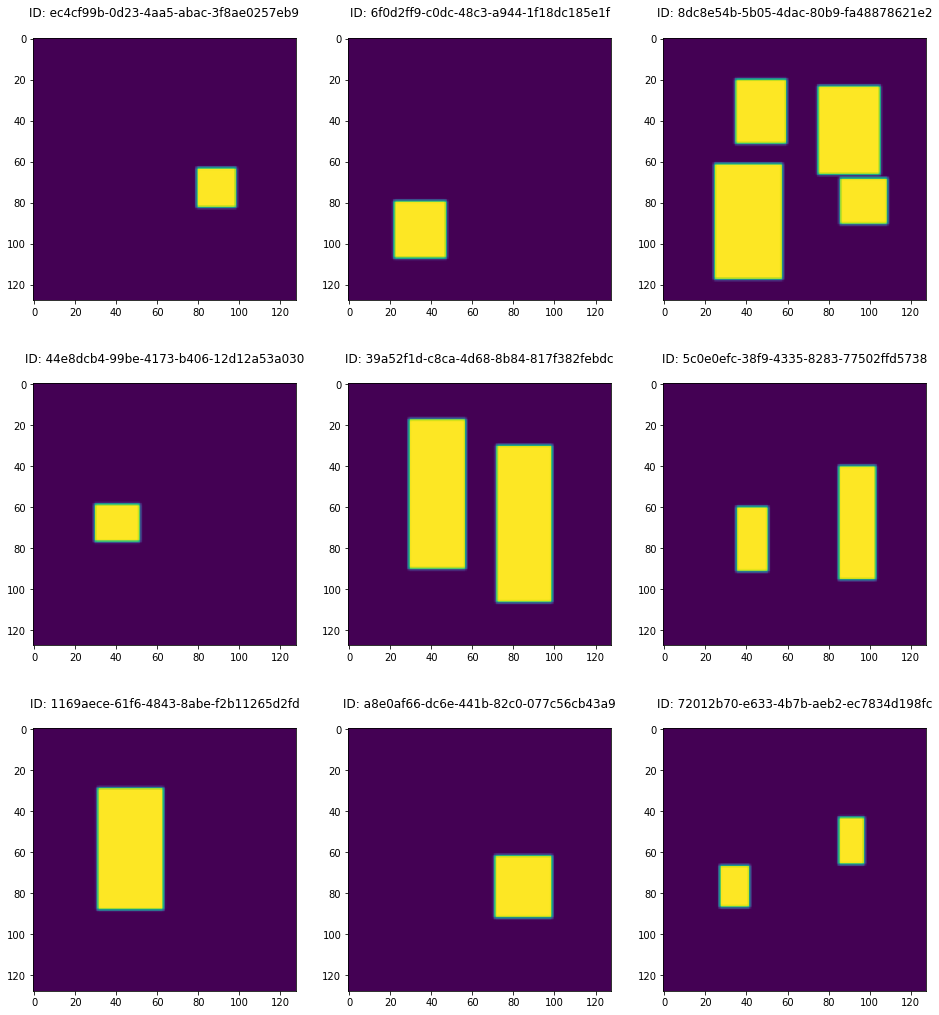

In [65]:
c = 0
f, ax = plt.subplots(3,3, figsize=(16,18))
# Target = 1
for patientId in image_ids:
  plot_masks (filt_class_df, ax, patientId, c, True)
  c = c + 1

# Unet with MobileNet as Backbone

In [97]:
ROOT_DIR=data_path + '/' + 'Unet'
sys.path.append(os.path.join(data_path, 'Unet'))

In [98]:
def resizeMask(patientId, imgShape):
  res_mask=np.zeros(imgShape)
  for idx_a, row_a in merged_class_df[(merged_class_df['patientId']==patientId) & (merged_class_df['Target']==1)].iterrows():
    res_mask[int(row_a['y']):int(row_a['y'])+ int(row_a['height']), 
        int(row_a['x']): int(row_a['x']) + int(row_a['width'])] = 1
  res_mask = resize(res_mask, (target_mask_size, target_mask_size), mode='symmetric')
  return res_mask

In [99]:
def load_mask(image_list, image_array):
  mask_array = []
  for i in range(len(image_list)):
    patientId = image_list[i]
    imgShape = image_array[i].shape
    mask = resizeMask(patientId, imgShape)
    mask_array.append(mask)
  return np.array(mask_array)

In [100]:
def get_patient_list(data_df):
    plist=data_df['patientId'].tolist()
    return np.array(plist)

In [101]:
mask_array=[]
if not os.path.exists(data_path + '/' + 'filtered_res_masks_' + str(target_mask_size) + '.npz'):
  image_list = get_patient_list(filt_class_df)
  mask_array = load_mask(image_list, resized_array)
  np.savez_compressed(data_path + '/' + 'filtered_res_masks_' + str(target_mask_size) + '.npz', masks=mask_array)
else:
  mask_array = np.load(data_path + '/' + 'filtered_res_masks_' + str(target_mask_size) + '.npz', allow_pickle=True)['masks']

In [102]:
test_mask_array=[]
if not os.path.exists(data_path + '/' + 'filtered_res_test_masks_' + str(target_mask_size) + '.npz'):
  test_image_list = get_patient_list(filt_test_class_df)
  test_mask_array = load_mask(test_image_list, resized_test_array)
  np.savez_compressed(data_path + '/' + 'filtered_res_test_masks_' + str(target_mask_size) + '.npz', masks=test_mask_array)
else:
  test_mask_array = np.load(data_path + '/' + 'filtered_res_test_masks_' + str(target_mask_size) + '.npz', allow_pickle=True)['masks']

In [103]:
random.seed(0)
X_train, X_val, y_train, y_val = train_test_split(resized_array, mask_array, test_size=0.15)

In [104]:
y_train = y_train.astype(float)
y_val = y_val.astype(float)
test_mask_array=test_mask_array.astype(float)

In [105]:
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
resized_test_array = np.expand_dims(resized_test_array, -1)
test_mask_array = np.expand_dims(test_mask_array, -1)

In [106]:
del resized_array, mask_array

In [107]:
def create_unet_model():
  model_mobnet = MobileNet(input_shape=(target_img_size, target_img_size, 1), weights=None, include_top=False)
  conn_layer=['conv_pw_11_relu', 'conv_pw_5_relu', 'conv_pw_3_relu', 'conv_pw_1_relu']
  filtersize=[512, 256, 128, 64]
  for layer in model_mobnet.layers:
    layer.trainable = False
  layer_d = model_mobnet.get_layer('conv_pw_13_relu').output

  for i in range(len(conn_layer)):
    layer_d = UpSampling2D()(layer_d)
    layer_d = Conv2DTranspose(filtersize[i], kernel_size=2, padding='same', activation='relu')(layer_d)
    enc_layer = model_mobnet.get_layer(conn_layer[i]).output
    layer_d = Concatenate()([layer_d, enc_layer])
    layer_d = Conv2D(filtersize[i], kernel_size=3, kernel_initializer='he_normal', padding='same', activation='relu')(layer_d)
    layer_d = Conv2D(filtersize[i], kernel_size=3, kernel_initializer='he_normal', padding='same', activation='relu')(layer_d)
  layer_d = Conv2D(1, 1, activation = 'sigmoid')(layer_d)
  model = Model(model_mobnet.input, layer_d)
  return model

In [108]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [109]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [110]:
def get_callbacks(filepath, min_lr, patience=10):
    msave = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, verbose=1, mode='min', min_lr = min_lr)
    return [lr_reduce, msave]

In [111]:
unet_model = None
unet_model = create_unet_model()
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 128, 128, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [112]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
unet_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [113]:
callbacks = get_callbacks(data_path + '/Unet/' + 'unet_best_weights.hdf5', min_lr=1e-7)

In [104]:
EPOCHS=30
BATCH_SIZE=20

In [105]:
history=unet_model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, callbacks=callbacks)

Epoch 1/30
289/289 [==============================] - 45s 147ms/step - loss: 4.2119 - dice_coefficient: 0.0605 - val_loss: 2.9387 - val_dice_coefficient: 0.1282

Epoch 00001: val_loss improved from inf to 2.93866, saving model to /content/drive/MyDrive/Colab/Capstone Project/dataset/Unet/unet_best_weights.hdf5
Epoch 2/30
289/289 [==============================] - 42s 144ms/step - loss: 3.2327 - dice_coefficient: 0.1164 - val_loss: 2.9182 - val_dice_coefficient: 0.1237

Epoch 00002: val_loss improved from 2.93866 to 2.91819, saving model to /content/drive/MyDrive/Colab/Capstone Project/dataset/Unet/unet_best_weights.hdf5
Epoch 3/30
289/289 [==============================] - 42s 144ms/step - loss: 3.0681 - dice_coefficient: 0.1152 - val_loss: 2.9185 - val_dice_coefficient: 0.1306

Epoch 00003: val_loss did not improve from 2.91819
Epoch 4/30
289/289 [==============================] - 41s 144ms/step - loss: 3.1821 - dice_coefficient: 0.1126 - val_loss: 2.9171 - val_dice_coefficient: 0.127

In [108]:
def plot_loss_coeff_curves(history, l1='Training', l2='Validation'):
    plt.figure(figsize=(10,6));
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label=l1 + " loss")
    ax[0].plot(history.history['val_loss'], color='r', label=l2 + "loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[1].plot(history.history['dice_coefficient'], color='b', label=l1+ " coefficient")
    ax[1].plot(history.history['val_dice_coefficient'], color='r',label=l2 + " coefficient")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.show()

<Figure size 720x432 with 0 Axes>

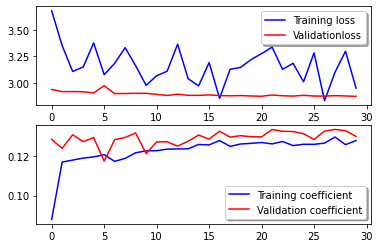

In [109]:
plot_loss_coeff_curves(history)

In [114]:
unet_model.load_weights(data_path + '/Unet/' + 'unet_best_weights.hdf5')
pred_test = unet_model.predict(resized_test_array, verbose=1)

11/11 [==============================] - 21s 296ms/step


In [115]:
pred_test_thr = (pred_test >= 0.5).astype(np.float64)
pred_test_mask = pred_test_thr.reshape(len(pred_test_thr),target_mask_size, target_mask_size)

In [118]:
pred_test_mask = np.expand_dims(pred_test_mask, -1)

In [121]:
print("Testing performance")
print ("===============================")
print ("Dice coefficient", dice_coefficient(test_mask_array, pred_test_mask))

Testing performance
Dice coefficient tf.Tensor(0.13960829762109794, shape=(), dtype=float64)
